# DS_7331 Machine Learning - Lab 3 - Group 4

### Paticia Attah
### Linda Eliasen

In [100]:
import numpy as np
import pickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from surprise import Dataset
from surprise import Reader
from surprise import KNNWithMeans
from surprise import SlopeOne
from surprise import CoClustering
from surprise import SVD
from surprise import SVDpp
from surprise import NMF
from surprise import BaselineOnly
from surprise.model_selection import cross_validate
from surprise import accuracy
from surprise.model_selection import GridSearchCV
from collections import defaultdict
import os
from surprise.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

### BUSINESS UNDERSTANDING 1

XXXX

### DATA UNDERSTANDING 1

### DATA MEANING  & TYPE

xxx

Bringing in the data

In [93]:
df1 = pd.read_csv('ratings_Electronics.csv', names=['userId', 'productId','Rating','timestamp'])

df1.head(10)

,userId,productId,Rating,timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200
5,A1QGNMC6O1VW39,0511189877,5.0,1397433600
6,A3J3BRHTDRFJ2G,0511189877,2.0,1397433600
7,A2TY0BTJOTENPG,0511189877,5.0,1395878400
8,A34ATBPOK6HCHY,0511189877,5.0,1395532800
9,A89DO69P0XZ27,0511189877,5.0,1395446400


In [94]:
#Dropping the Timestamp column as it is not needed 
df1.drop(['timestamp'], axis=1,inplace=True)

In [95]:
df1.shape

(7824482, 3)

In [96]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824482 entries, 0 to 7824481
Data columns (total 3 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     object 
 1   productId  object 
 2   Rating     float64
dtypes: float64(1), object(2)
memory usage: 179.1+ MB


In [97]:
#summary statistics

dfssc = pd.DataFrame([df1.Rating]).T
dfssc.describe()

,Rating
count,7.824482e+06
mean,4.012337e+00
std,1.380910e+00
min,1.000000e+00
25%,3.000000e+00
50%,5.000000e+00
75%,5.000000e+00
max,5.000000e+00


In [98]:
# minimum and maximum ratings

print('Minimum rating is: %d' %(df1.Rating.min()))
print('Maximum rating is: %d' %(df1.Rating.max()))

Minimum rating is: 1
Maximum rating is: 5


In [99]:
#Check for missing values

print('Number of missing values across columns: \n',df1.isnull().sum())

Number of missing values across columns: 
 userId       0
productId    0
Rating       0
dtype: int64


### DATA UNDERSTANDING 2

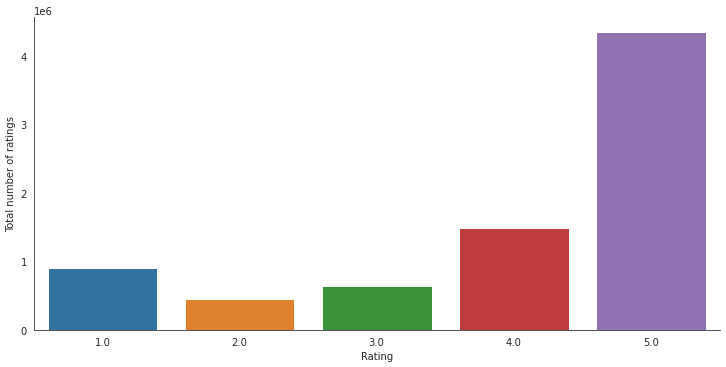

In [101]:
# Check the distribution of the rating
with sns.axes_style('white'):
    g = sns.factorplot("Rating", data=df1, aspect=2.0,kind='count')
    g.set_ylabels("Total number of ratings")

In [ ]:
# GRAPH OF POPULAR ITEMS

In [103]:
print("Total data ")
print("-"*50)
print("\nTotal no of ratings :",df1.shape[0])
print("Total No of Users   :", len(np.unique(df1.userId)))
print("Total No of products  :", len(np.unique(df1.productId)))

Total data 
--------------------------------------------------

Total no of ratings : 7824482
Total No of Users   : 4201696
Total No of products  : 476002


In [104]:
#Ratings per user

RPU = df1.groupby(by='userId')['Rating'].count().sort_values(ascending=False)

RPU.head()

userId
A5JLAU2ARJ0BO     520
ADLVFFE4VBT8      501
A3OXHLG6DIBRW8    498
A6FIAB28IS79      431
A680RUE1FDO8B     406
Name: Rating, dtype: int64

In [105]:
RPU.describe()

count    4.201696e+06
mean     1.862220e+00
std      2.885110e+00
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      5.200000e+02
Name: Rating, dtype: float64

### MODELING AND EVALUATION 1

To reduce the dimensionality of the dataset and processing time, rarely rated products and users with minimal ratings are filetered out.  The final dataset will consist of users who provided 20 or more ratings and then a subsequent filter of products that received at least 50 ratings. 

In [106]:
#Subset of the data containing users who gave 20 or more ratings

df2=df1.groupby("userId").filter(lambda x:x['Rating'].count() >=20)

In [107]:
# Additioanl subset of the data containing products with 50 or more ratings

df3=df2.groupby("productId").filter(lambda x:x['Rating'].count() >=50)

In [108]:
#Resulting dataset

print("Total data ")
print("-"*50)
print("\nTotal no of ratings :",df3.shape[0])
print("Total No of Users   :", len(np.unique(df3.userId)))
print("Total No of products  :", len(np.unique(df3.productId)))

Total data 
--------------------------------------------------

Total no of ratings : 85410
Total No of Users   : 12933
Total No of products  : 880


In [109]:
#Revisiting 5 pt Summary and ratings distribution of condensed dataset

dfssc = pd.DataFrame([df3.Rating]).T
dfssc.describe()

,Rating
count,85410.000000
mean,4.407259
std,1.009711
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


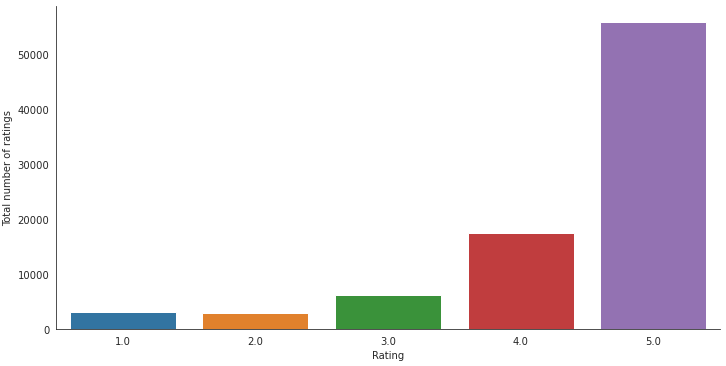

In [110]:
with sns.axes_style('white'):
    g = sns.factorplot("Rating", data=df3, aspect=2.0,kind='count')
    g.set_ylabels("Total number of ratings")

Reading the Data into Surprise

In [111]:
#Reading the dataset into Surprise
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df3,reader)

In [112]:
#Splitting the dataset into train and test - - reserving 30% for testing
trainset, testset = train_test_split(data, test_size=0.3,random_state=28)

In [113]:
print('Number of users: ', trainset.n_users, '\n')
print('Number of products: ', trainset.n_items, '\n')

Number of users:  12484 

Number of products:  880 



In [114]:
#to save a list of inner and raw item id’s:
trainset_iids = list(trainset.all_items())
iid_converter = lambda x: trainset.to_raw_iid(x)
trainset_raw_iids = list(map(iid_converter, trainset_iids))

**GridSearchCV** 

Utilized to compare accuracy metrics for algorithms on various combinations of parameters, over a cross-validation procedure to identify the best set of parameters for a prediction algorithm.

In [115]:
# Grid Search Parameters

param_grid = {'n_factors': [5, 10, 20],
              'n_epochs': [20, 30, 50],
              'lr_all': [0.002, 0.005, 0.01],
              'reg_all': [0.02, 0.05, 0.1]}

#n_factors: determines the size of your pᵤ and qᵢ vectors - - how many latent factors the model will try to find. 
#n_epochs: determines how many times the gradient descent calculations are repeated. 
#lr_all: Learning rate factor for all of the parameters. Step sizes the model will use to minimise the cost function
#reg_all: Regularisation factor for all of the parameters. Surprise uses an L2 regularisation

#### Neighborhood-based algorithm


MSD mean square difference
similarities will be computed between users user - item similarity

**KNN**

**KNN with Means**

Basic collaborative filtering algorithm, taking into account the mean ratings of each user.


In [116]:
# Tune algorithm parameters with GridSearchCV and k=5 cross-validation 
gskn = GridSearchCV(KNNWithMeans, param_grid, measures = ['rmse'], cv = 5)
gskn.fit(data)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computi

Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computi

Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd

In [117]:
# Best RMSE scores
gskn.best_score

{'rmse': 1.051526193006182}

#### Matrix Factorization-based algorithms

**NMF** 

In [ ]:
# Tune algorithm parameters with GridSearchCV and k=5 cross-validation 
gsnmf = GridSearchCV(NMF, param_grid, measures = ['rmse'], cv = 5)
gsnmf.fit(data)

In [ ]:
# Best RMSE
gsnmf.best_score

**SVD**

Singular Value Decomposition (SVD) for dimension reduction of a large User-Item Sparse matrix to provide more robust recommendations while avoiding computational complexity.

In [28]:
# Tune algorithm parameters with GridSearchCV and k=5 cross-validation 
gssvd = GridSearchCV(SVD, param_grid, measures = ['rmse'], cv = 5)
gssvd.fit(data)

In [29]:
# Best RMSE and MAE scores
gssvd.best_score

{'rmse': 0.940523432576805}

SVD ++

In [37]:
# Tune algorithm parameters with GridSearchCV and k=5 cross-validation 
gssvdp = GridSearchCV(SVDpp, param_grid, measures = ['rmse', 'mae'], cv = 5)
gssvdp.fit(data)

In [38]:
# Best RMSE and MAE scores
gssvdp.best_score

{'rmse': 0.9399084821777907, 'mae': 0.6589678689862317}

### MODELING & EVALUATION 2 - Evaluate and Compare

Select models based on rmse above or just a handful? Computing time...

PRECISION AND RECALL
https://surprise.readthedocs.io/en/stable/FAQ.html

In [52]:
# Return precision and recall at k metrics for each user
def precision_recall_at_k(predictions, k = 10, threshold = 3.5):
    
    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))
    
    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():
        
        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)
        
        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)
        
        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])
        
        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold)) for (est, true_r) in user_ratings[:k])
        
        # Precision@K: Proportion of recommended items that are relevant
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 1
        
        # Recall@K: Proportion of relevant items that are recommended
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 1
    
    return precisions, recalls;

In [57]:
# Returns the precision and recall of the model at k metrics
def get_precision_vs_recall(algo, k_max = 10, verbose = False):
    precision_list = []
    recall_list = []
    f1_score_list = []
    
    if algo:
        for k_curr in range(1, k_max + 1):
            algo.fit(trainset)
            predictions = algo.test(testset)
            
            # Get precision and recall at k metrics for each user
            precisions, recalls = precision_recall_at_k(predictions, k = k_curr, threshold = 4)
            
            # Precision and recall can then be averaged over all users
            precision = sum(prec for prec in precisions.values()) / len(precisions)
            recall = sum(rec for rec in recalls.values()) / len(recalls)
            f1_score = 2 * (precision * recall) / (precision + recall)
            
            # Save measures
            precision_list.append(precision)
            recall_list.append(recall)
            f1_score_list.append(f1_score)
            
            if verbose:
                print('K =', k_curr, '- Precision:', precision, ', Recall:', recall, ', F1 score:', f1_score)
    
    return {'precision': precision_list, 'recall': recall_list, 'f1_score': f1_score_list};

In [119]:
# Check if works, otherwise delete

sim_options = {'name': 'cosine',
               'user_based': True  # compute  similarities between users
               }


**kNN with Means**

In [35]:
# Combination of parameters that gave the best scores
gskn.best_params

{'rmse': {'n_factors': 5, 'n_epochs': 20, 'lr_all': 0.002, 'reg_all': 0.02}}

In [122]:
# Check if works otherwise delete

#algo = gskn.best_estimator['rmse'] (sim_options=sim_options)
algo = KNNWithMeans(n_factors=5, n_epochs=20, lr_all=0.002, reg_all=0.02, verbose=False,sim_options=sim_options )
algo.fit = algo.fit(trainset)
predictions = algo.test(testset)
accuracy.rmse(predictions, verbose=False)

1.068035585448013

In [36]:
#algo = gskn.best_estimator['rmse']
#algo.fit = algo.fit(trainset)
#predictions = algo.test(testset)
#accuracy.rmse(predictions, verbose=False)

Computing the msd similarity matrix...
Done computing similarity matrix.


1.073823036512019

In [124]:
# Use KNN algorithm with the best params
#algo = gssvdp.best_estimator['rmse'] 
algo = KNNWithMeans(n_factors=5, n_epochs=20, lr_all=0.002, reg_all=0.02, verbose=False,sim_options=sim_options)

In [125]:
# Calculate the precision and recall of the model at k metrics
k_max = 10
metrics = get_precision_vs_recall(algo, k_max, True)

K = 1 - Precision: 0.9126680404278285 , Recall: 0.5199032267555717 , F1 score: 0.6624439147213
K = 2 - Precision: 0.9076145618683151 , Recall: 0.6899834598038382 , F1 score: 0.7839757273995381
K = 3 - Precision: 0.9068622640892311 , Recall: 0.7566145786460331 , F1 score: 0.8249531249327509
K = 4 - Precision: 0.9056275144735564 , Recall: 0.7837289282662444 , F1 score: 0.8402803142901953
K = 5 - Precision: 0.9051368854871974 , Recall: 0.7953501040991974 , F1 score: 0.846699469628245
K = 6 - Precision: 0.9046953193994722 , Recall: 0.8008592403346827 , F1 score: 0.8496164512515362
K = 7 - Precision: 0.9045574760175895 , Recall: 0.8039928097259528 , F1 score: 0.851315542504508
K = 9 - Precision: 0.9043563570719902 , Recall: 0.8067105121948527 , F1 score: 0.8527472457377603
K = 10 - Precision: 0.9042942107337181 , Recall: 0.8073378159506254 , F1 score: 0.853069937566894


**NMF** 

In [ ]:
# Combination of parameters that gave the best scores
gsnmf.best_params

In [ ]:
algo = gsnmf.best_estimator['rmse'] 
algo.fit = algo.fit(trainset)
predictions = algo.test(testset)
accuracy.rmse(predictions, verbose=False)

In [61]:
# Use NMF algorithm with the best params
#algo = gssvdp.best_estimator['rmse'] 
#algo = NMF(n_factors=5, n_epochs=30, lr_all=0.005, reg_all=0.1, verbose=False)

In [72]:
# Calculate the precision and recall of the model at k metrics
k_max = 10
metrics = get_precision_vs_recall(algo, k_max, True)

K = 1 - Precision: 0.9136492984005495 , Recall: 0.576714089655224 , F1 score: 0.707095232765458
K = 2 - Precision: 0.9016779511333529 , Recall: 0.7644880039826907 , F1 score: 0.8274349562605603
K = 3 - Precision: 0.8981127138324699 , Recall: 0.8362295258941866 , F1 score: 0.8660670906637603
K = 4 - Precision: 0.896166552186572 , Recall: 0.8653763195692148 , F1 score: 0.8805023426756127
K = 5 - Precision: 0.8956726523403038 , Recall: 0.8798127263230792 , F1 score: 0.8876718531377429
K = 6 - Precision: 0.8946570503385367 , Recall: 0.8844740184740408 , F1 score: 0.8895363926134858
K = 7 - Precision: 0.894540000280362 , Recall: 0.8879446871205735 , F1 score: 0.8912301421494577
K = 8 - Precision: 0.8938726280424866 , Recall: 0.8899252394550882 , F1 score: 0.8918945661360258
K = 9 - Precision: 0.8938575587236198 , Recall: 0.8908186886050601 , F1 score: 0.8923355364355328
K = 10 - Precision: 0.8948207880280324 , Recall: 0.8918856324751856 , F1 score: 0.8933507993524202


**SVD**

xx

In [30]:
# Combination of parameters that gave the best scores
gssvd.best_params

{'rmse': {'n_factors': 5, 'n_epochs': 50, 'lr_all': 0.002, 'reg_all': 0.1}}

In [31]:
algo = gssvd.best_estimator['rmse'] 
algo.fit = algo.fit(trainset)
predictions = algo.test(testset)
accuracy.rmse(predictions, verbose=False)

0.9399026894947793

In [61]:
# Use SVD algorithm with the best params
#algo = gssvdp.best_estimator['rmse'] 
algo = SVD(n_factors=5, n_epochs=50, lr_all=0.002, reg_all=0.1, verbose=False)

In [72]:
# Calculate the precision and recall of the model at k metrics
k_max = 10
metrics = get_precision_vs_recall(algo, k_max, True)

K = 1 - Precision: 0.9136492984005495 , Recall: 0.576714089655224 , F1 score: 0.707095232765458
K = 2 - Precision: 0.9016779511333529 , Recall: 0.7644880039826907 , F1 score: 0.8274349562605603
K = 3 - Precision: 0.8981127138324699 , Recall: 0.8362295258941866 , F1 score: 0.8660670906637603
K = 4 - Precision: 0.896166552186572 , Recall: 0.8653763195692148 , F1 score: 0.8805023426756127
K = 5 - Precision: 0.8956726523403038 , Recall: 0.8798127263230792 , F1 score: 0.8876718531377429
K = 6 - Precision: 0.8946570503385367 , Recall: 0.8844740184740408 , F1 score: 0.8895363926134858
K = 7 - Precision: 0.894540000280362 , Recall: 0.8879446871205735 , F1 score: 0.8912301421494577
K = 8 - Precision: 0.8938726280424866 , Recall: 0.8899252394550882 , F1 score: 0.8918945661360258
K = 9 - Precision: 0.8938575587236198 , Recall: 0.8908186886050601 , F1 score: 0.8923355364355328
K = 10 - Precision: 0.8948207880280324 , Recall: 0.8918856324751856 , F1 score: 0.8933507993524202


SVD ++

In [39]:
# Combination of parameters that gave the best scores
gssvdp.best_params

{'rmse': {'n_factors': 5, 'n_epochs': 30, 'lr_all': 0.005, 'reg_all': 0.1},
 'mae': {'n_factors': 5, 'n_epochs': 50, 'lr_all': 0.005, 'reg_all': 0.1}}

In [40]:
algo = gssvdp.best_estimator['rmse'] 
algo.fit = algo.fit(trainset)
predictions = algo.test(testset)
accuracy.rmse(predictions, verbose=False)

0.9392419347311924

In [61]:
# Use SVD algorithm with the best params
#algo = gssvdp.best_estimator['rmse'] 
algo = SVDpp(n_factors=5, n_epochs=30, lr_all=0.005, reg_all=0.1, verbose=False)

In [72]:
# Calculate the precision and recall of the model at k metrics
k_max = 10
metrics = get_precision_vs_recall(algo, k_max, True)

K = 1 - Precision: 0.9136492984005495 , Recall: 0.576714089655224 , F1 score: 0.707095232765458
K = 2 - Precision: 0.9016779511333529 , Recall: 0.7644880039826907 , F1 score: 0.8274349562605603
K = 3 - Precision: 0.8981127138324699 , Recall: 0.8362295258941866 , F1 score: 0.8660670906637603
K = 4 - Precision: 0.896166552186572 , Recall: 0.8653763195692148 , F1 score: 0.8805023426756127
K = 5 - Precision: 0.8956726523403038 , Recall: 0.8798127263230792 , F1 score: 0.8876718531377429
K = 6 - Precision: 0.8946570503385367 , Recall: 0.8844740184740408 , F1 score: 0.8895363926134858
K = 7 - Precision: 0.894540000280362 , Recall: 0.8879446871205735 , F1 score: 0.8912301421494577
K = 8 - Precision: 0.8938726280424866 , Recall: 0.8899252394550882 , F1 score: 0.8918945661360258
K = 9 - Precision: 0.8938575587236198 , Recall: 0.8908186886050601 , F1 score: 0.8923355364355328
K = 10 - Precision: 0.8948207880280324 , Recall: 0.8918856324751856 , F1 score: 0.8933507993524202


In [58]:
# Show best params for best algo
#gssvdp.best_params['rmse']

{'n_factors': 5, 'n_epochs': 30, 'lr_all': 0.005, 'reg_all': 0.1}

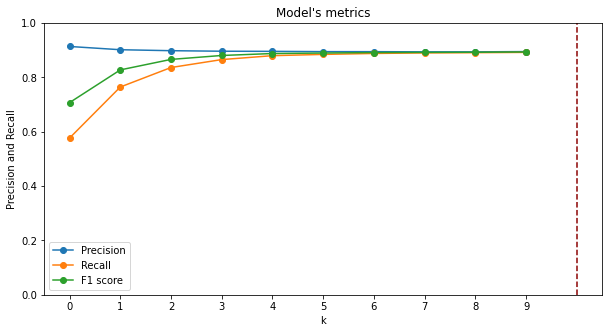

In [77]:
# Get data
c1 = metrics['precision']
c2 = metrics['recall']
c3 = metrics['f1_score']
x = np.arange(len(c1))

# Set up the matplotlib figure
fig, ax1 = plt.subplots(figsize = (10, 5))
plt.xticks(np.arange(min(x), max(x) + 1, 1.0))
plt.ylim(0, 1)
ax1.plot(x, c1, marker = 'o')
ax1.plot(x, c2, marker = 'o')
ax1.plot(x, c3, marker = 'o')
ax1.axvline(x = 10, color = "#8b0000", linestyle = "--")

# Chart setup
plt.title("Model's metrics", fontsize = 12)
plt.xlabel("k", fontsize = 10)
plt.ylabel("Precision and Recall", fontsize = 10)
plt.legend(("Precision", "Recall", "F1 score"), loc = "best")
plt.draw()

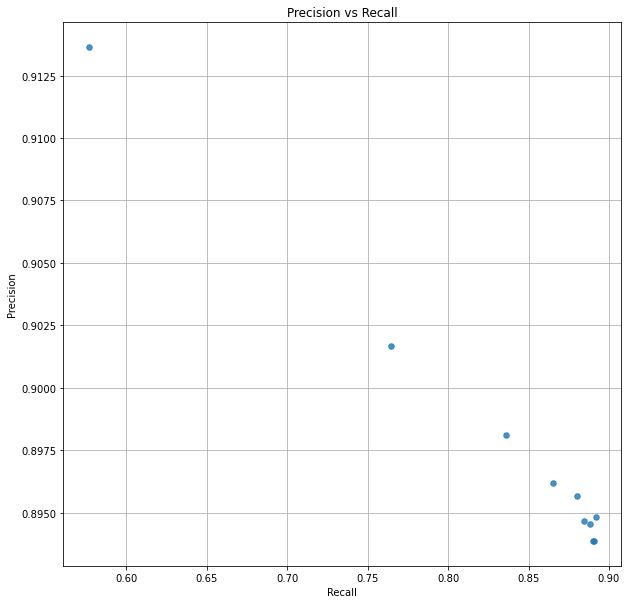

In [74]:
# Get data
x = metrics['recall']
y = metrics['precision']

# Create scatter plot with the precision and recall results
fig, ax2 = plt.subplots(figsize = (10, 10))

# Create 2D scatter plot
sns.regplot(ax = ax2, x = x, y = y, fit_reg = False, marker = "o", color = "#1f77b4", scatter_kws = {"s": 30})

# Plot setup
ax2.set_title("Precision vs Recall", fontsize = 12)
ax2.set_xlabel("Recall", fontsize = 10)
ax2.set_ylabel("Precision", fontsize = 10)
ax2.grid()

In [ ]:
#https://nbviewer.jupyter.org/github/NicolasHug/Surprise/blob/master/examples/notebooks/Compare.ipynb
#http://webcache.googleusercontent.com/search?q=cache:AqFH2uo4cQsJ:https://towardsdatascience.com/movie-recommender-system-52e4651f3ae7&hl=en&gl=us&strip=1&vwsrc=0
#https://surprise.readthedocs.io/en/v1.0.1/getting_started.html
#https://towardsdatascience.com/building-and-testing-recommender-systems-with-surprise-step-by-step-d4ba702ef80b
#https://www.kaggle.com/saurav9786/recommender-system-using-amazon-reviews